In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import tensorflow as tf
import skimage.transform as skTrans
from sklearn.model_selection import train_test_split
import scipy
import torch
import io
from io import BytesIO
import seaborn as sns
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.python.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D, InputLayer
from tensorflow.keras.layers import BatchNormalization
from keras import Input

In [ ]:
participant_metadata = pd.read_csv("drive/MyDrive/dementia/ADNI1_Complete_1Yr_1.5T_11_16_2022.csv")
participant_metadata.head()
participant_metadata = participant_metadata[['Image Data ID', 'Group','Age', 'Sex']]
participant_metadata.rename(columns={'Image Data ID':'MRI_ID', 'Group':'Diagnosis'}, inplace=True)

In [ ]:
participant_metadata.head()

,MRI_ID,Diagnosis,Age,Sex
0,I97327,MCI,69,M
1,I112538,MCI,70,M
2,I97341,MCI,70,M
3,I63874,CN,78,M
4,I75150,CN,78,M


In [ ]:
#making dataframe with paths of mri and corresponding diagnosis
path = "drive/MyDrive/dementia"
list_dir = os.listdir(path)
final_df = pd.DataFrame(columns=["MRI_Path", "Diagnosis"])
for i in range(0,2294):
	for nifti in list_dir:
		if participant_metadata.MRI_ID[i] in nifti:
			print(str(participant_metadata.MRI_ID[i]) + " added")
			new_row = {"MRI_Path" : nifti, "Diagnosis" : participant_metadata.Diagnosis[i]}
			final_df = pd.concat([final_df,pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
print(final_df.groupby(final_df.Diagnosis).count())


           MRI_Path
Diagnosis          
AD              320
CN              443
MCI             715


In [ ]:
list_of_paths = []
diagnosis = []

In [ ]:
def show_slices(img):
	slice_x = img[70,:,:]
	slice_y = img[:,70,:]
	slice_z = img[:,:,70]
	slices = [slice_x, slice_y, slice_z]

	fig,axis = plt.subplots(1,len(slices))
	for i, slice in enumerate(slices):
	  axis[i].imshow(slice.T, cmap="gray", origin="lower")
	plt.show()

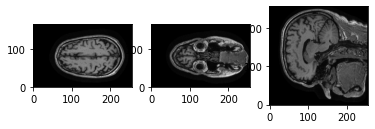

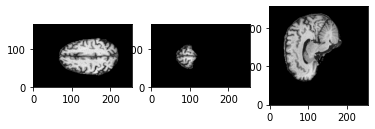

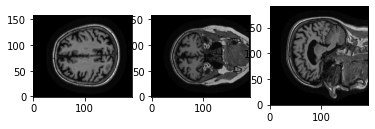

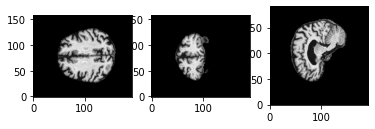

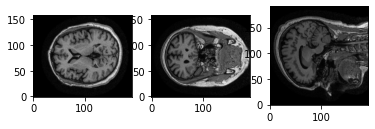

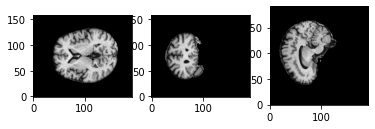

In [ ]:
mci_ = nib.load("drive/MyDrive/ADNI_133_S_0792_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008094227100_S29222_I119622.nii").get_fdata()
show_slices(mci_)
mci_stripped = nib.load("drive/MyDrive/dementia/stripped_ADNI_133_S_0792_MR_MPR__GradWarp__B1_Correction__N3__Scaled_2_Br_20081008094227100_S29222_I119622.nii").get_fdata()
show_slices(mci_stripped)

ad_ = nib.load("drive/MyDrive/ADNI_023_S_1262_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080421170310500_S47813_I103322.nii").get_fdata()
show_slices(ad_)
ad_stripped = nib.load("drive/MyDrive/dementia/stripped_ADNI_023_S_1262_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080421170310500_S47813_I103322.nii").get_fdata()
show_slices(ad_stripped)

cn_ = nib.load("drive/MyDrive/ADNI_067_S_0059_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070111010838738_S10517_I35902.nii").get_fdata()
show_slices(cn_)
cn_stripped = nib.load("drive/MyDrive/dementia/stripped_ADNI_067_S_0059_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070111010838738_S10517_I35902.nii").get_fdata()
show_slices(cn_stripped)


In [ ]:
list_of_paths = final_df['MRI_Path'].tolist()
diagnosis = final_df['Diagnosis'].tolist()

In [ ]:
def remove_zero_rows_columns_slices(data):
    # Find the slices that have only zero values
    blank_slices = np.where(~np.all(data == 0, axis=(1, 2)))[0]
    
    # Remove the blank slices from the beginning and end of the data
    first_valid_slice = 0 if len(blank_slices) == 0 else blank_slices[0]
    last_valid_slice = data.shape[0] - 1 if len(blank_slices) == 0 else blank_slices[-1]
    data = data[first_valid_slice:last_valid_slice + 1, :, :]
    
    # Find the rows that have only zero values
    blank_rows = np.where(~np.all(data == 0, axis=(0, 2)))[0]
    
    # Remove the blank rows from the beginning and end of the data
    first_valid_row = 0 if len(blank_rows) == 0 else blank_rows[0]
    last_valid_row = data.shape[1] - 1 if len(blank_rows) == 0 else blank_rows[-1]
    data = data[:, first_valid_row:last_valid_row + 1, :]
    
    # Find the columns that have only zero values
    blank_columns = np.where(~np.all(data == 0, axis=(0, 1)))[0]
    
    # Remove the blank columns from the beginning and end of the data
    first_valid_column = 0 if len(blank_columns) == 0 else blank_columns[0]
    last_valid_column = data.shape[2] - 1 if len(blank_columns) == 0 else blank_columns[-1]
    data = data[:, :, first_valid_column:last_valid_column + 1]
    
    return data

(256, 256, 166)
(256, 256, 166)


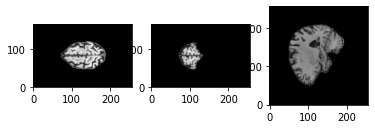

(161, 170, 117)


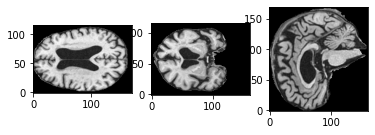

In [ ]:
mri = nib.load("drive/MyDrive/dementia/" + list_of_paths[200])
data = mri.get_fdata()
or_shape = data.shape
print(mri.shape)
print(or_shape)

show_slices(data)
#or_voxel_size = find_voxel_size(mri) 
#print(or_voxel_size)

removed_shape = remove_zero_rows_columns_slices(data).shape
print(removed_shape)
show_slices(remove_zero_rows_columns_slices(data))
#new_voxel = or_voxel_size*(np.array(or_shape) / np.array(removed_shape))
#print(new_voxel)

In [ ]:
def find_voxel_size(mri):
  return mri.header["pixdim"][1:4]

In [ ]:
print(nib.load("drive/MyDrive/dementia/" + list_of_paths[10]).shape)
print(find_voxel_size(nib.load("drive/MyDrive/dementia/" + list_of_paths[10])))
print(nib.load("drive/MyDrive/dementia/" + list_of_paths[210]).shape)
print(find_voxel_size(nib.load("drive/MyDrive/dementia/" + list_of_paths[200])))

(192, 192, 160)
[1.2519437 1.24822   1.1999664]
(192, 192, 160)
[0.94105595 0.9442997  1.2049919 ]


In [ ]:
from collections import Counter


In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_trainn, y_testt = train_test_split(list_of_paths, diagnosis, test_size=0.2, random_state=127)
X_val, X_test, y_vall, y_testt = train_test_split(X_test, y_testt, test_size=0.5, random_state=127)

# Print the number of samples in each set
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Testing samples:", len(X_test))

Training samples: 1182
Validation samples: 148
Testing samples: 148


In [ ]:
# Define the label encoding and one-hot encoding mappings
label_encoder = {'CN': 0, 'MCI': 1, 'AD': 2}
one_hot_encoder = {0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]}

# Encode the labels as integers using the label encoder
encoded_train_labels = np.array([label_encoder[label] for label in y_trainn])
encoded_val_labels = np.array([label_encoder[label] for label in y_vall])
encoded_test_labels = np.array([label_encoder[label] for label in y_testt])


# Use a list comprehension to one-hot encode the labels
y_train = np.array([one_hot_encoder[label] for label in encoded_train_labels])
y_val = np.array([one_hot_encoder[label] for label in encoded_val_labels])
y_test = np.array([one_hot_encoder[label] for label in encoded_test_labels])


# Print the one-hot encoded labels
print(y_train)

[[0 1 0]
 [1 0 0]
 [0 0 1]
 ...
 [1 0 0]
 [0 1 0]
 [0 1 0]]


In [ ]:
def get_train_nifti_diagnosis_tuple(niftipath_diag):
  for j in range (len(X_train)):
    niftipath_diag.append((X_train[j], y_train[j]))
  return niftipath_diag

def get_val_nifti_diagnosis_tuple(niftipath_diag):
  for j in range (len(X_val)):
    niftipath_diag.append((X_val[j], y_val[j]))
  return niftipath_diag

def get_test_nifti(niftipath):
  for j in range(len(X_test)):
    niftipath.append(X_test[j])
  return niftipath

In [ ]:
empty1 = []
tuples_of_train_filepaths_diagnosis = get_train_nifti_diagnosis_tuple(empty1)
print(len(tuples_of_train_filepaths_diagnosis))

empty2 = []
tuples_of_val_filepaths_diagnosis = get_val_nifti_diagnosis_tuple(empty2)
print(len(tuples_of_val_filepaths_diagnosis))

empty3 = []
test_filepaths = get_test_nifti(empty3)
print(len(test_filepaths))

1182
148
148


In [ ]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [ ]:
def create_train_tfrecord(outfile, tuples):
  path = "/content/drive/MyDrive/dementia/"
  writer = tf.io.TFRecordWriter(outfile)
  for nifti_path, diagnosis in tuples:

    print("Processing:")
    print("  nifti: ", nifti_path)
    print("  diagnosis:  ", diagnosis)	

    nii = nib.load(path + nifti_path)

    # Add the non-augmented data to the TFRecord file
    nii_data = nii.get_fdata().astype('float32')
    non_zero_nii = remove_zero_rows_columns_slices(nii_data)
    resized = skTrans.resize(non_zero_nii, (90,90,70), order=3, preserve_range=True)

    print("Normalized MRI added to tfrecord .. ")

    data_point = tf.train.Example(features=tf.train.Features(feature={
      'nifti': _float_feature(resized.flatten()),
      'diagnosis': _int64_feature(diagnosis)}))
    writer.write(data_point.SerializeToString())


  writer.close()

In [ ]:
def create_val_tfrecord(outfile, tuples):
  path = "/content/drive/MyDrive/dementia/"
  writer = tf.io.TFRecordWriter(outfile)
  for nifti_path, diagnosis in tuples:

    print("Processing:")
    print("  nifti: ", nifti_path)
    print("  diagnosis:  ", diagnosis)

    nii = nib.load(path + nifti_path)
	
    nii_data = nii.get_fdata().astype('float32')
    non_zero_nii = remove_zero_rows_columns_slices(nii_data)
    resized = skTrans.resize(non_zero_nii, (90,90,70), order=3, preserve_range=True)


    # Dimensions
    rows, cols, slices = resized.shape

    print("DIMS: rows:" + str(rows) + " - cols:" + str(cols) + " - slices:"+ str(slices))


    data_point = tf.train.Example(features=tf.train.Features(feature={
      'nifti': _float_feature(resized.flatten()),
      'diagnosis': _int64_feature(diagnosis)})) #ta raw ta exw kanei toString ara bytes feature
      
        
    writer.write(data_point.SerializeToString())

  writer.close()

In [ ]:
def create_test_tfrecord(outfile, niftis): #no diagnosis
  path = "/content/drive/MyDrive/dementia/"
  writer = tf.io.TFRecordWriter(outfile)
  for nifti_path in niftis:

    print("Processing:")
    print("  nifti: ", nifti_path)

    nii = nib.load(path + nifti_path)

    nii_data = nii.get_fdata().astype('float32')
    non_zero_nii = remove_zero_rows_columns_slices(nii_data)
    resized = skTrans.resize(non_zero_nii, (90,90,70), order=3, preserve_range=True)


    # Dimensions
    rows, cols, slices = resized.shape

    print("DIMS: rows:" + str(cols) + " - cols:" + str(cols) + " - slices:"+ str(slices))


    data_point = tf.train.Example(features=tf.train.Features(feature={
      'nifti': _float_feature(resized.flatten())})) 
        
    writer.write(data_point.SerializeToString())

  writer.close()

In [ ]:
equalratio_threeclass_train = "/content/drive/MyDrive/dementia/equalratio_threeclass_train" #NUM_AUGM = 5
create_train_tfrecord(equalratio_threeclass_train, tuples_of_train_filepaths_diagnosis)

In [ ]:
equalratio_threeclass_val = "/content/drive/MyDrive/dementia/equalratio_threeclass_val"
create_val_tfrecord(equalratio_threeclass_val, tuples_of_val_filepaths_diagnosis)

In [ ]:
equalratio_threeclass_test = "/content/drive/MyDrive/dementia/equalratio_threeclass_test"
create_test_tfrecord(equalratio_threeclass_test, X_test)

In [ ]:
threeclass_train = "/content/drive/MyDrive/dementia/equalratio_threeclass_train"
threeclass_val = "/content/drive/MyDrive/dementia/equalratio_threeclass_val"
threeclass_test = "/content/drive/MyDrive/dementia/equalratio_threeclass_test"

In [ ]:
record_iterator = tf.compat.v1.io.tf_record_iterator(threeclass_train)

counter = 0
for string_record in record_iterator:
    counter += 1

print(counter)

In [ ]:
def decode(serialized_example):
  features = tf.io.parse_single_example(
    serialized_example,
    features={'nifti': tf.io.FixedLenFeature([90,90,70], tf.float32),
    'diagnosis': tf.io.FixedLenFeature([3], tf.int64)})
  return features['nifti'], features['diagnosis']

In [ ]:
def decode_test(serialized_example):
  features = tf.io.parse_single_example(
    serialized_example,
    features={'nifti': tf.io.FixedLenFeature([90,90,70], tf.float32)})

  return features['nifti']

In [ ]:
train_dataset = tf.data.TFRecordDataset(threeclass_train).shuffle(1182).map(decode)
val_dataset = tf.data.TFRecordDataset(threeclass_val).map(decode)
test_dataset = tf.data.TFRecordDataset(threeclass_test).map(decode_test)

In [ ]:
BATCH_SIZE = 16

def create_data_batches(dataset, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  if test_data:
    print("Creating data batches .. ") #niftis only
    data_batches = dataset.batch(BATCH_SIZE)

    return data_batches
  
  elif valid_data:
    print("Creating valid data batches ..") #niftis and diagnosis
    data_batches = dataset.batch(BATCH_SIZE)
    return data_batches
  
  else:
    print("Creating train data batches ..")
    data_batches = dataset.shuffle(len(X_test)).batch(BATCH_SIZE)
    return data_batches

In [ ]:
test_data = create_data_batches(test_dataset, test_data = True)
val_data = create_data_batches(val_dataset, valid_data = True)
train_data = create_data_batches(train_dataset)

Creating data batches .. 
Creating valid data batches ..
Creating train data batches ..


In [ ]:
test_data, val_data, train_data #to None antistoixei sto batch size

(<BatchDataset element_spec=TensorSpec(shape=(None, 90, 90, 70), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 90, 90, 70), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 90, 90, 70), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.int64, name=None))>)

In [ ]:
#functional
from keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout,Concatenate 
from keras.models import Model
from keras import regularizers


In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.scale * (inputs - mean) / tf.sqrt(variance + 1e-5) + self.offset

In [ ]:
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, AveragePooling3D, Add, Multiply, GlobalAveragePooling3D, Dense, Reshape
from tensorflow.keras.models import Model


def residual_block(inputs, filters):
    x = Conv3D(filters, (3, 3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(inputs)
    else:
        shortcut = inputs
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def attention_block(inputs, filters):
    g = Conv3D(filters, (1, 1, 1), padding='same')(inputs)
    g = Activation('relu')(g)
    g = Multiply()([g, inputs])
    return g

# Define input shape
input_shape = (90,90,70,1)
inputs = Input(shape=input_shape)

x = InstanceNormalization()(inputs) # instance normalization

# First convolutional layer

x = Conv3D(32, (3, 3, 3), padding='same')(x)
x = Activation('relu')(x)
x = residual_block(x, 32)

x = AveragePooling3D((3, 3, 3))(x)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)


y = attention_block(x,64)
x = Multiply()([x, y])

x = AveragePooling3D((3, 3, 3))(x)
x = residual_block(x, 128)
x = residual_block(x, 128)


x = AveragePooling3D((3, 3, 3))(x)
x = residual_block(x, 256)
x = residual_block(x, 256)


# Global average pooling layer
x = GlobalAveragePooling3D()(x)

x = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=x)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 90, 90, 70,  0           []                               
                                 1)]                                                              
                                                                                                  
 instance_normalization (Instan  (None, 90, 90, 70,   2          ['input_2[0][0]']                
 ceNormalization)               1)                                                                
                                                                                                  
 conv3d (Conv3D)                (None, 90, 90, 70,   896         ['instance_normalization[0][0]'] 
                                32)                                                           

In [ ]:
from keras.losses import categorical_crossentropy
from sklearn.utils import compute_class_weight

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy


In [ ]:
# Define a callback to save the model weights after each epoch
checkpoint = ModelCheckpoint(filepath='drive/MyDrive/dementia/weights12.{epoch:02d}-{val_accuracy:.2f}.h5',
                             monitor='val_accuracy',
                             save_best_only=True)

In [ ]:
class_weights = {0: 1/343, 1: 1/615, 2: 1/220}

sum_weights = sum(class_weights.values())
for i in range(len(class_weights)):
    class_weights[i] /= sum_weights

In [ ]:
class_weights = {0: 0.32, 1: 0.18, 2: 0.5}

# define the loss function with class weights
cce = CategoricalCrossentropy(from_logits=False, label_smoothing=0.1)

def weighted_categorical_crossentropy(y_true, y_pred):
    # compute the weighted loss
    weights = tf.gather(list(class_weights.values()), tf.argmax(y_true, axis=-1))
    loss = cce(y_true, y_pred, sample_weight=weights)
    return loss

In [ ]:
model.compile("adam", loss = weighted_categorical_crossentropy, metrics = ['accuracy'])

# Train your model with class weights
history = model.fit(train_data,
                    epochs=70,
                    validation_data = val_data,
                    callbacks = [checkpoint])


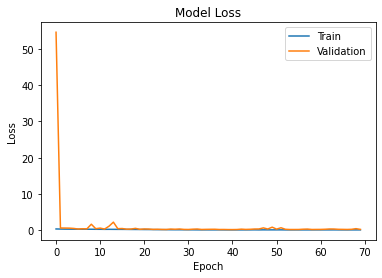

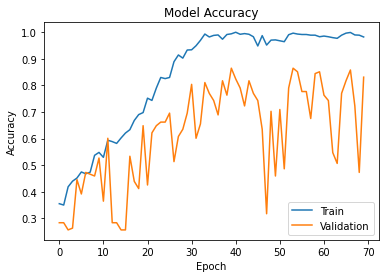

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

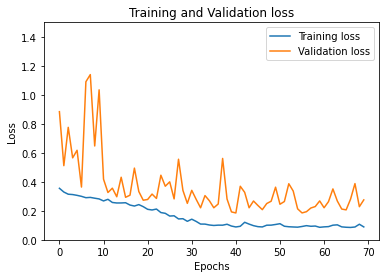

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Set y-axis limits to zoom in on specific range of loss values

plt.ylim([0, 1.5])  # Set y-axis limits to zoom in on range of loss values

plt.show()

In [ ]:
tf.keras.utils.get_custom_objects()['InstanceNormalization'] = InstanceNormalization

In [ ]:
from keras.models import load_model

# Load the model using the custom_objects argument
model = load_model('drive/MyDrive/dementia/weights12.57-0.92.h5', custom_objects={'weighted_categorical_crossentropy': weighted_categorical_crossentropy, 'InstanceNormalization' : InstanceNormalization})


In [ ]:
y_pred = model.predict(test_data)
y_pred_rounded = np.round(y_pred)
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_rounded)
print(accuracy)

In [ ]:
y_pred = np.argmax(y_pred_rounded, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

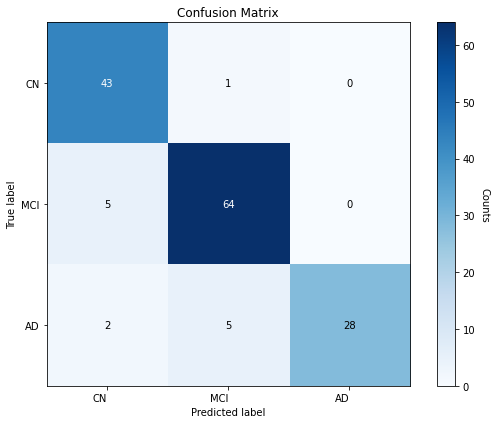

In [ ]:
labels = ['CN', 'MCI', 'AD']

# Normalize the matrix
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define color map and figure size
# Define color map and figure size
cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(8, 6))

# Create matrix plot with color scale
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

# Add color bar legend
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Counts', rotation=-90, va='bottom')

# Add labels, title, and axis ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       xlabel='Predicted label', ylabel='True label',
       title='Confusion Matrix')
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Add text annotations to cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()